In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leukemia-dataset/test/test/CML TEST-20230225T083148Z-001/CML TEST/cml test_original_20190121_145304.jpg_17755bdb-1a85-4f8d-86ee-6a4663f1e2bb.jpg
/kaggle/input/leukemia-dataset/test/test/CML TEST-20230225T083148Z-001/CML TEST/cml test_original_20190121_144230.jpg_cb26ffc5-2a40-4662-9dc8-c418e08f52f6.jpg
/kaggle/input/leukemia-dataset/test/test/CML TEST-20230225T083148Z-001/CML TEST/cml test_original_20190121_145257.jpg_4bade483-4c10-4c2e-91e2-d81595f3c3d1.jpg
/kaggle/input/leukemia-dataset/test/test/CML TEST-20230225T083148Z-001/CML TEST/cml test_original_20190121_145606.jpg_accee6f7-ddec-4f63-8503-992bd495ecec.jpg
/kaggle/input/leukemia-dataset/test/test/CML TEST-20230225T083148Z-001/CML TEST/cml test_original_20190125_170711.jpg_896ab2c0-c0d4-48b5-a3d9-cf3002d75906.jpg
/kaggle/input/leukemia-dataset/test/test/CML TEST-20230225T083148Z-001/CML TEST/cml test_original_20190121_145415.jpg_2c13f002-f587-4485-9b58-592bbdf7b858.jpg
/kaggle/input/leukemia-dataset/test/test/CML T

# 📌 Leukemia Classification Pipeline

In [5]:
# ✅ Step 1: Imports and Setup
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

# ✅ GPU Check and Uniform Memory Growth Setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ {len(gpus)} GPU(s) detected and memory growth set.")
    except RuntimeError as e:
        print("❌ Could not set memory growth:", e)
else:
    print("❌ No GPU detected. Training will be on CPU.")


✅ 2 GPU(s) detected and memory growth set.


In [60]:
# ✅ Step 2: Load Images directly from original nested folder
data_dir = "/kaggle/input/leukemia-dataset/train/train"

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="training"  # later use "validation" for val_ds_raw
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="validation"
)

Found 15000 files belonging to 5 classes.
Using 12000 files for training.
Found 15000 files belonging to 5 classes.
Using 3000 files for validation.


In [61]:
# ✅ Step 3: Preprocessing Function
import cv2
import tensorflow as tf
import numpy as np

# --- OpenCV CLAHE logic wrapped in NumPy
def apply_clahe_np(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def preprocess_fn(image, label):
    def apply_clahe_py(img_np):
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_np)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Apply CLAHE via NumPy
    image = tf.numpy_function(apply_clahe_py, [image], tf.uint8)

    # 🔧 Restore static shape (Keras requires this!)
    image.set_shape([None, None, 3])

    # Resize & Normalize
    image = tf.image.resize(image, (224, 224))
    image.set_shape([224, 224, 3])  # 🔥 Crucial fix
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

In [62]:
# ✅ Step 4: Split into Train/Validation
# Use a portion of train_ds_raw for validation manually
cardinality = tf.data.experimental.cardinality(train_ds_raw).numpy()
val_size = int(0.2 * cardinality)

print(f"📊 Total Batches: {cardinality}")
print(f"🧪 Validation Batches: {val_size}")
print(f"🏋️‍♂️ Training Batches: {cardinality - val_size}")

val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

📊 Total Batches: 375
🧪 Validation Batches: 75
🏋️‍♂️ Training Batches: 300


In [63]:
from tensorflow.keras import layers, models, regularizers

num_classes = len(train_ds_raw.class_names)

# 🔄 Data Augmentation Pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
], name="data_augmentation")

# 🧠 Base Model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base for now

# 🔧 Architecture
inputs = tf.keras.Input(shape=(224, 224, 3), name="input_image")
x = layers.RandomFlip('horizontal')(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs, name="EfficientNetB0_Classifier")

# ⚙️ Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "EfficientNetB0_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_9 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_9               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_9 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,061,096 (15.49 MB)

 Trainable params: 8,965 (35.02 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [64]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime

# ⏹️ Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# 💾 Model Checkpoint
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# 📊 TensorBoard callback for monitoring (if you want logs)
log_dir = f"/kaggle/working/logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

# 🚀 Train the model
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=15,
        callbacks=[early_stop, checkpoint],  # Optionally add tensorboard_cb
        verbose=1
    )

Epoch 1/15


ValueError: Input 0 of layer "EfficientNetB0_Classifier" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(224, 224, 3)

In [47]:
# 🔓 Unfreeze the top N layers (e.g., last 20 layers)
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# ✅ Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 🚀 Fine-tune
fine_tune_epochs = 10
total_epochs = 15 + fine_tune_epochs  # previous + fine-tuning

with tf.device('/GPU:0'):
    history_fine = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=total_epochs,
        initial_epoch=15,  # continue from previous
        callbacks=[early_stop, checkpoint],
        verbose=1
    )


Epoch 16/25


E0000 00:00:1753272447.863433      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetB0_Classifier_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1911 - loss: 2.5667
Epoch 16: val_loss did not improve from 1.32113
300/300 ━━━━━━━━━━━━━━━━━━━━ 55s 118ms/step - accuracy: 0.1911 - loss: 2.5659 - val_accuracy: 0.2092 - val_loss: 2.7149
Epoch 17/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2594 - loss: 2.0096
Epoch 17: val_loss did not improve from 1.32113
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 105ms/step - accuracy: 0.2594 - loss: 2.0096 - val_accuracy: 0.2087 - val_loss: 1.8473
Epoch 18/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2829 - loss: 1.9167
Epoch 18: val_loss did not improve from 1.32113
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.2829 - loss: 1.9167 - val_accuracy: 0.2129 - val_loss: 1.9064
Epoch 19/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2937 - loss: 1.8552
Epoch 19: val_loss did not improve from 1.32113
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.2937 - loss: 1.8551 - val_accuracy: 0.2546 - val_l

/tmp/ipykernel_36/2730196459.py:27: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_36/2730196459.py:27: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()


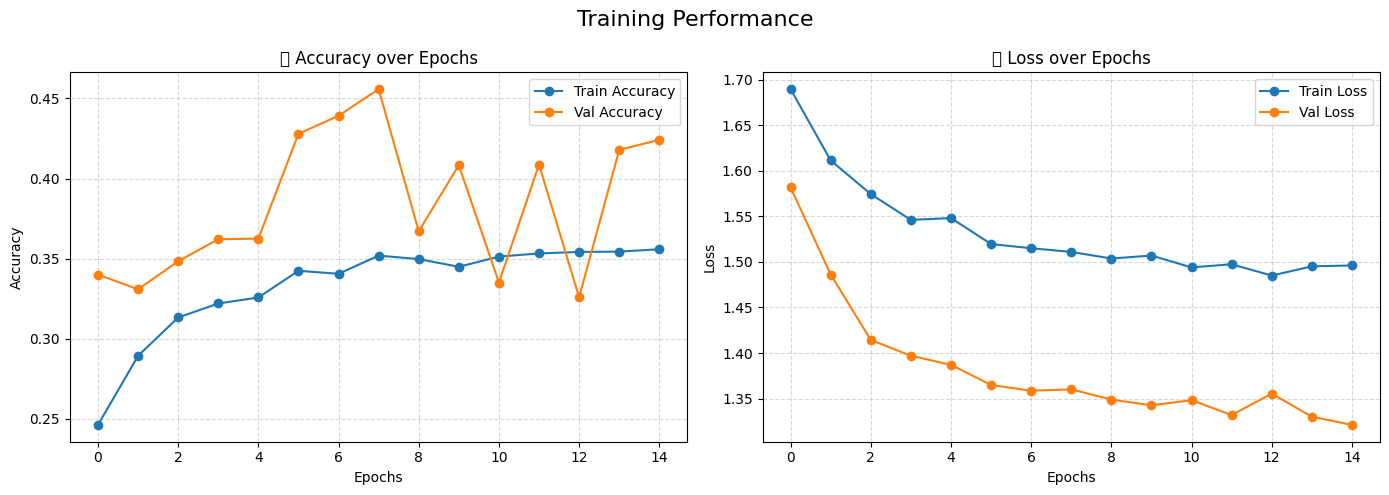

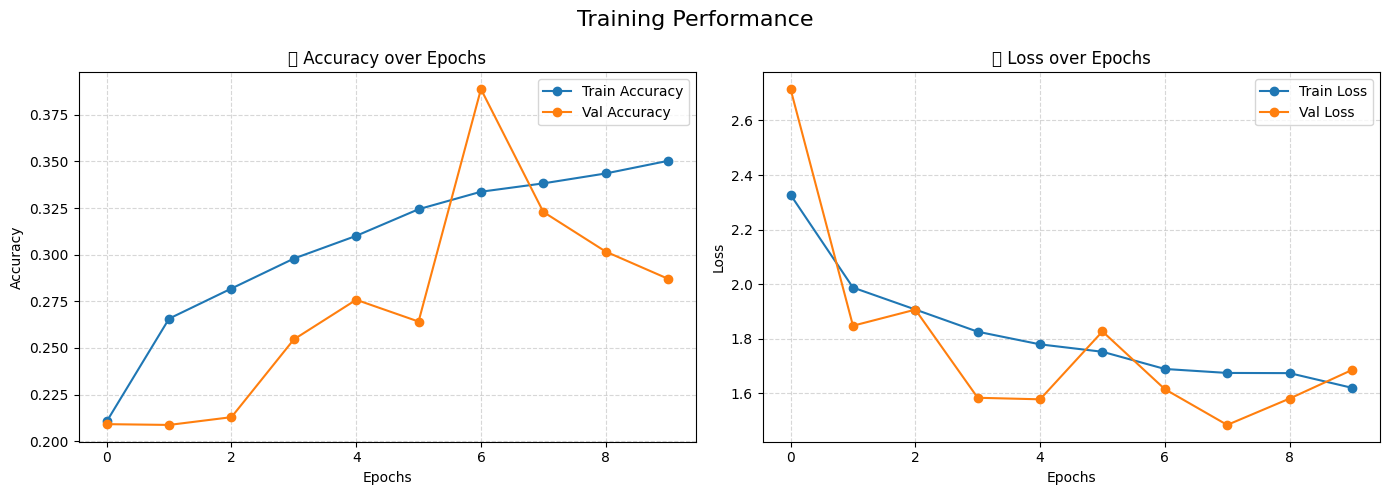

In [50]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('📈 Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('📉 Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    plt.suptitle("Training Performance", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)
plot_training_history(history_fine)



In [ ]:
# ✅ Step 8: Save Trained Model
model.save('/kaggle/working/leukemia_classification_model.h5')